In [273]:
import pickle
import os,sys,inspect
currentdir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe()))
        )
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/solve"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/visualization"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/data"))
import lloovia
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [275]:
import matplotlib
# Parámetros de las gráficas para publicación en artículo
sb_white=dict(matplotlib.style.library["seaborn-whitegrid"])
sb_paper=dict(matplotlib.style.library["seaborn-paper"])
my_settings = {
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": (3.5, 2.5),
    'grid.linestyle': '-',
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,
    "lines.markersize": 3,
    "lines.linewidth": 0.8,
    "text.usetex": False,   
    "font.family": "serif",
    "pgf.rcfonts": False,
    "font.serif": [],   
    "font.sans-serif": [],
    "font.monospace": [],
}
paper_style = {}
for x in [sb_white, sb_paper, my_settings]:
    paper_style.update(x)
    
# Parámetros para verlas en el notebook
notebook_style = {}
my_settings = {
   "figure.figsize": (7, 5)
}
for x in [dict(matplotlib.style.library["seaborn-darkgrid"]),
          dict(matplotlib.style.library["seaborn-notebook"])]:
    notebook_style.update(x)

# Synthetic experiments

## Cloud infrastructure parameters

The set of instace classes used in the synthetic experiments can be read from a pickle, and processed using Pandas to provide a summary table similar to Table 5 in the paper.

In [428]:
# Show the characteristics of the instances used in the experiments
instances = pd.read_pickle("/tmp/interim/instances_for_synthetic_experiments.pickle")
(pd.DataFrame([i.__dict__ for i in instances])
 [["name", "cloud", "performance", "price", "reserved"]]
 .assign(region=lambda x: x.cloud.astype(str).str.replace(" .*", ""))
 .drop("cloud", axis=1)
# .reset_index()
 .pivot_table(index=["name", "region"], columns="reserved", values=["price", "performance"])
 .sort_index()
 )

performance           price          
reserved                False    True   False     True 
name       region                                      
c3.2xlarge EU         46000.0  46000.0  0.478  0.307534
           US         46000.0  46000.0  0.420  0.247717
c3.large   EU         18000.0  18000.0  0.120  0.076598
           US         18000.0  18000.0  0.105  0.061872
c3.xlarge  EU         27000.0  27000.0  0.239  0.154224
           US         27000.0  27000.0  0.210  0.124772
m3.large   EU         11000.0  11000.0  0.146  0.100114
           US         11000.0  11000.0  0.133  0.081393
m3.medium  EU          9000.0   9000.0  0.073  0.049543
           US          9000.0   9000.0  0.067  0.040297
m3.xlarge  EU         39000.0  39000.0  0.293  0.199315
           US         39000.0  39000.0  0.266  0.163014

## Workload parameters

Several workload shapes were used in each experiment. They are stored in `.csv` files, each one containing several columns for different base-level. There are two files for each workload shape, one is used as LTWP for Phase I and the other as STWP for Phase II in the "realization" experiment. All were synthetically generated and they can be regenerated to perform a new set of experiments if desired. Refer to README.

This is the complete set of `.csv` files


In [429]:
!ls ../data/paper/traces_synthetic_*

../data/paper/traces_synthetic_decreasing_LTWP.csv
../data/paper/traces_synthetic_decreasing_STWP.csv
../data/paper/traces_synthetic_everything_LTWP.csv
../data/paper/traces_synthetic_everything_STWP.csv
../data/paper/traces_synthetic_increasing_LTWP.csv
../data/paper/traces_synthetic_increasing_STWP.csv
../data/paper/traces_synthetic_once_LTWP.csv
../data/paper/traces_synthetic_once_STWP.csv
../data/paper/traces_synthetic_periodic_LTWP.csv
../data/paper/traces_synthetic_periodic_STWP.csv
../data/paper/traces_synthetic_static_LTWP.csv
../data/paper/traces_synthetic_static_STWP.csv
../data/paper/traces_synthetic_unpredictable_LTWP.csv
../data/paper/traces_synthetic_unpredictable_STWP.csv


This is a plot which shows each workload shape, all for the LTWP version and base-level = 3000000. This is Fig. 8 in the paper

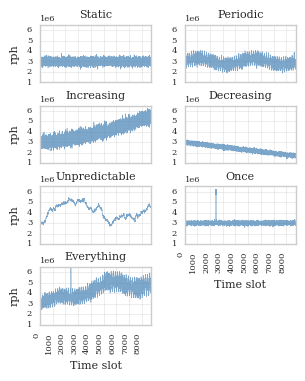

In [742]:
# Load all workloads from CSVs
cases = df.index.levels[0]            # Names of each case
dfw = pd.DataFrame()
for case in cases:
    data = pd.read_csv("../data/processed/traces_synthetic_{}_LTWP.csv".format(case.lower()),
                       index_col=0).T
    data["Case"] = case
    data["Level"] = data.index
    data.set_index(["Case", "Level"])
    dfw = dfw.append(data)
dfw = dfw.set_index(["Case", "Level"]).reindex().sort_index().T

# Plot them all in a single graph (only for base_level=3000000)

# Workloads
k = dfw.loc[:, pd.IndexSlice[:, "3000000"]].astype(float)
k.index.name = "Time slot"
# Nombres de los casos
k.columns = k.columns.get_level_values(0)

# Force this given order in the subplots
selection = ["Static", "Periodic", "Increasing", 
             "Decreasing", "Unpredictable", "Once", "Everything"]

with matplotlib.style.context(paper_style):
    axarr = k[selection].plot(subplots=True, sharex=True, layout=(4,2),
                              lw=0.4, color="steelblue", alpha=0.7, legend=False, 
                              rot=90,
                              figsize=(3.3,5))#, fontsize=7)
    plt.subplots_adjust(left=None, bottom=0.3, right=None, top=None,
                        wspace=0.3,  hspace=0.4)
    for ax, title in zip(axarr.flat, selection):
        ax.set_title(title)#, fontsize=11)
        # Lo siguiente fuerza a usar notación científica
        ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
        ax.set_ylim(1e6,6.5e6)
for ax in axarr[:,0]:
    ax.set_ylabel("rph", rotation=90)
plt.gcf().savefig("../reports/figures/fig-008-synthetic-workloads.pgf", bbox_inches="tight")

## Solutions

There are 7 workload shapes, and each one in 4 different "base level", which makes a total of 28 scenarios. Each of these scenarios is solved several times: 

* Phase I is run 11 times over each scenario, for different value of `max_bins`, plus another one without binning (the "optimal"). This makes 28*12=336 experiments. We call this phase "I"
* Phase II is run 11 times, using the same prediction than phase I (perfect prediction) and using the number of reserved instances given by Phase I for each of the 11 cases of binning. This makes 28*11=308 additional experiments. We call this phase "II".
* Phase II is run again 11 times, for each solution with bins in phase "I", but using this time different workloads as STWP, to evaluate the sensibilty of the solution to the accuracy of the prediction. This makes 28*11=308 additional experiments. We call this phase "R" (Realization).
* An "Oracle" solution is found for each of the 28 scenarios. This oracle knows the future STWP and is able to obtain an optimal solution for the STWP. It is implemented by running phase I of lloovia without binning, but passing the STWP instead of the LTWP as input. This makes additional 28 experiments. We call this phase "O" (Oracle).

In total there are 980 experiments. In order to bound the total time required for running them all, we set timeouts to find the solution in each experiment. Phase "I" experiments are limited to 15 minutes for the cases with binning, and 1 hour for the cases without binning. Phase "II" and "R" do not use binning and they have a time limit per timeslot which is never reached (because a single timeslot solves usually very fast), so in practice they do not require any timeout. Phase "O" is run without binning and with a timeout of 1h.

Given the large number of experiments, the time to complete all of them is large (around 32h in a Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz). You can replicate the experiment using the Snakefiles provided, which automate all the workflow. Alternatively you can use the provided pickle which summarizes the results of all these experiments in a single dataframe, useful to explore and plot the data. All intermediate pickles produced during the analysis are not provided in this repository, because they take a large space in disk (~1.5Gb). Those pickles contain the individual allocation found by Lllovia for each timeslot of each of the 980 experiments.



### Read the final solution from file

In [463]:
df = pd.read_pickle("../data/processed/all_experiments_result.pickle")

The resulting dataframe is multi-indexed by the name of each case, the base-level, the phase and the number of `max_bins` used. There is one row per experiment. Fore example, here is the first one:

In [446]:
df.head(1)

,,,,cost,seconds_to_solve,seconds_to_create,frac_gap,max_seconds,status
Case,Base level,Phase,max_bins,,,,,,
Decreasing,50000,I,5,1677.188,0.048798,0.014099,0.01,900.0,optimal


It shows data about the case "Decreasing" with base level 50000, phase "I" with 5 bins. The only data stored per experiment is the final cost of the solution, the time required to create and solve the problem, some parameters passed to cbc (frac_gap and the timeout max_seconds), and the status of the solution. This status can be one of:

* `optimal` The solver ran until the end and found the optimal solution (for that number of bins)
* `aborted` The time limit given in `max_seconds` was reached, and no solution was found. In this case, the value of column `cost` is the best lower bound known by the solver at that point. 
* `overfull` This can only happen in phase "R", when the actual workload (STWP) is creater than predicted in LTWP. In this csae, is it possible that at some timeslots the workload cannot be fulfilled with the available ondemand instances. In this case Lloovia tries to maximize the performance during those timeslots, no matter the cost.

**Note about the timeout:** The value of `max_seconds` passed to the cbc solver is not "wall time". Cbc divides that time between the number of execution threads. In our case, we used a machine with two cores and ran cbc in two threads. This means that, when `max_seconds=900`, the solver will abort the execution if it runs for more than 450 seconds.

In [454]:
for phase in ["I", "II", "R", "O"]:
    print("Number of experiment results in phase %-2s = %d" % 
          (phase, len(df.query("Phase=='%s'" % phase ))))

Number of experiment results in phase I  = 336
Number of experiment results in phase II = 308
Number of experiment results in phase R  = 28
Number of experiment results in phase O  = 28


Some general statistics about the number of solved/aborted experiments, per phase. 

In [455]:
df.reset_index().groupby("Phase").status.value_counts()

Phase  status  
I      optimal     294
       aborted      42
II     optimal     281
O      aborted      14
       optimal      14
R      optimal      27
       overfull      1
Name: status, dtype: int64

## Phase I

### Graphics of solving time

In [748]:
def time_plot(all_data, case, level, 
              ax=None, legend=True, title=True, plot_phase_II=True):
    # Get the data for the given case and level
    data = all_data.loc[(case, level, "I"), 
                        ["seconds_to_create", "seconds_to_solve", "status"]
                       ].reset_index()   
    if title:
        title="{} {}".format(case, level)
    else:
        title=""
    labels = ["sec to create", "sec to solve"]
    ax = data.plot(x="max_bins", y="seconds_to_create",
                   title=title, marker="o", color="RoyalBlue",
                   ax=ax, legend=legend)
    ax = data.plot(x="max_bins", y="seconds_to_solve",
                  marker="s", ls="solid", color="DarkRed",
                  ax=ax, legend=legend)
    
    if plot_phase_II:
        data2 = all_data.loc[(case, level, "II"), 
                ["seconds_to_create", "seconds_to_solve"]].reset_index()
        data2.plot(x="max_bins", y=["seconds_to_create", "seconds_to_solve"], 
                         marker="s", markersize=3, ax=ax, legend=legend)
        labels = [x + " I" for x in labels]
        labels+= ["sec to create II", "sec to solve II"]

    aborted = data[data.status.str.contains("aborted") |
                   data.status.str.contains("error")]
    if len(aborted):
        aborted.plot(ax=ax, x="max_bins", y=["seconds_to_solve"], 
                     linestyle="", color="y", 
                     marker = "D", markerfacecolor="white",
                     markeredgecolor="k", 
                     markeredgewidth=0.5,
                     legend=legend)
        labels+=["aborted"]
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    requested_bins = [int(x) for x in data.max_bins.tolist()]
    requested_bins = [5, 20, 80, 400, 1600, 8760]
    ax.set_xticks(requested_bins)
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    ax.set_xlabel("Bins")
    ax.set_yticks([0.1, 1, 10, 60, 60*10, 60*60])
    ax.set_yticklabels(["0.1s", "1s", "10s", "1min", "10min", "1h"])
    ax.set_ylim(0,60*80)
    ax.set_xlim(0,10000)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if legend:
        L=ax.legend(labels=labels, loc="best")
    return ax

This function allows us to plot the relationship between the value of `max_bins` and the time required to create and solve each problem, for any of the cases and load-levels. For exmple:

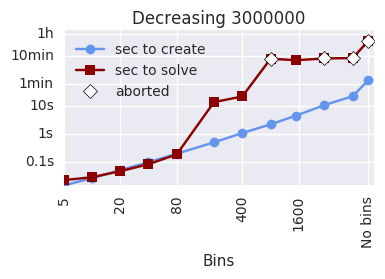

In [747]:
with matplotlib.style.context(notebook_style):
    time_plot(df, "Decreasing", 3000000, plot_phase_II=False)
    plt.gcf().set_size_inches((4,2))

The following code plots a grid with all cases and levels. It is Fig. 9 in the paper

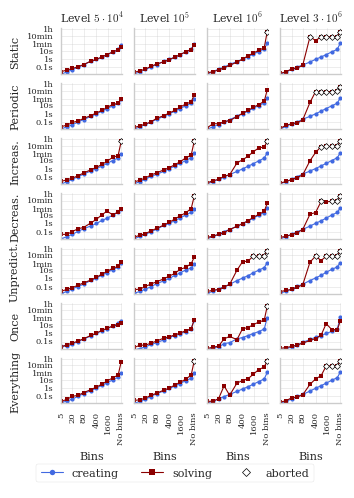

In [749]:
# Set the order of the rows in the grid of plots
casetitles = ["Static", "Periodic", "Increasing", "Decreasing",
              "Unpredictable", "Once", "Everything"]

# Select the order of the columns in the grid of plots
levels = [50000,100000,1000000,3000000]

with matplotlib.style.context(paper_style):
    # Create the subplots array
    f, axarr = plt.subplots (len(casetitles), len(levels), sharex=True, 
                             sharey=True, figsize=(15,30))

    # Plot each subplot
    for i,case in enumerate(casetitles):
        for j,level in enumerate(levels):
            a = time_plot(df, case, level, 
                          ax=axarr[i,j], legend=False, title=False, 
                          plot_phase_II=False)
            
    # Set the size of the figure for the paper
    f.set_size_inches(3.5,5)

    # Create titles for rows and columns. Some case names are abridged
    # to fit in the small space
    for ax, casetitle in zip(axarr[:,0], 
            ["Static", "Periodic", "Increas.", "Decreas.", 
             "Unpredict.", "Once", "Everything"]):
        ax.set_ylabel(casetitle, rotation=90)
        
    # For the column titles we use scientific notation to save space
    for ax, level in zip(axarr[0,:], ["5\cdot10^4", 
                                      "10^5", 
                                      "10^6", 
                                      "3\cdot10^6" ]):
        ax.set_title("Level ${}$".format(level))

    # Create a custom legend
    patches, labels = axarr[-1,-1].get_legend_handles_labels()
    f.legend(patches, labels=["creating", "solving", "aborted"], 
             bbox_to_anchor=(0.5, 0.05), loc="center",
             markerscale=1.3,
             ncol=3, shadow=False, fancybox=True, framealpha=0.8, 
             frameon=True)
    f.subplots_adjust(bottom=0.2, left=0.15,right=0.95, top=0.95)
    f.savefig("../reports/figures/fig-009-binning-analysis-time.pgf", 
          bbox_inches = matplotlib.transforms.Bbox([[-0.05,0.05], [3.5, 5.1]]))

## Phase II (Perfect Prediction)

### Overcost

In the dataframe we have the total cost (in dollars) of each solution. In order to compare each solution which used binning with the optimal solution which used no binning, it is more relevant to compute the percentage of overcost. It is defined as:

```
overcost = 100*(cost_of_solution_with_binning - cost_of_solution_without_binning)/cost_of_solution_without_binning
```

However in some cases the solution without binning is not available because the solver was aborted due to the timeout. In those cases, instead of the optimal cost we use the lower bound of the optimal cost. This comparison is conservative, in the sense that the actual overcost would be smaller.

In [476]:
import itertools
for case, level in itertools.product(df.index.levels[0], df.index.levels[1]):
    # We get the optimal solution from phase I, for each case/level
    optimal = df.loc[(case, level, "I"), "cost"].loc[8760]
    # Compute the overcost, and add it as a new column in the dataframe
    df.loc[pd.IndexSlice[case, level, "I":"II", :], "% overcost"] = (df.loc[
                           pd.IndexSlice[case, level, "I":"II", :],"cost"]
                                            -optimal)*100/optimal
    # For the realization phase we compare against the oracle
    oracle = df.loc[(case, level, "O"), "cost"].loc[8760]
    df.loc[pd.IndexSlice[case, level, "R", :], "% overcost"] = (df.loc[
                           pd.IndexSlice[case, level, "R", :],"cost"]
                                            -oracle)*100/oracle

The overcost is computed for both phases I, II and R, but in phase I it does not have much sense. Using binning, the solution in phase I is not optimal, and thus the overcost can be large. However, phase II will refine the result by recomputing the optimal number of ondemand instances with the actual workload, without binning, and this will reduce the overcost. So we will study only the overcost for phase II (both in "II" and "R" cases)

In [485]:
df.query("Phase=='II'").head()

cost  seconds_to_solve  \
Case       Base level Phase max_bins                               
Decreasing 50000      II    5         1626.268          0.151164   
                            10        1535.590        151.136600   
                            20        1535.590        168.320099   
                            40        1535.590        170.825480   
                            80        1535.590        162.678686   

                                      seconds_to_create frac_gap  max_seconds  \
Case       Base level Phase max_bins                                            
Decreasing 50000      II    5                  0.007354     None        600.0   
                            10                11.808506     None        600.0   
                            20                12.977067     None        600.0   
                            40                12.589924     None        600.0   
                            80                12.354026     None        600.0   

                                       status    % overcost  
Case       Base level Phase max_bins                         
Decreasing 50000      II    5         optimal  5.905092e+00  
                            10        optimal  3.287138e-12  
                            20        optimal  3.287138e-12  
                            40        optimal  3.287138e-12  
                            80        optimal  3.287138e-12

### Graphics of overcost

In [497]:
def plot_cost(all_data, case, level, ax = None,
              plot_phase_I = False, legend=True):  
    phase1 = all_data.loc[(case, level, "I"), :].reset_index()
    phase2 = all_data.loc[(case, level, "II"), :].reset_index()
    optimal_status = phase1.status.iloc[-1]
    if optimal_status=="aborted":
        label="% resp. best lower bound"
        style1 = dict(color="orange", ls="solid",
                     # dashes=(1,1),
                     marker="o", markerfacecolor="white",
                     markeredgecolor="k", 
                     markeredgewidth=0.5,
                     markersize=2.5,
                     label=label)
        style2 = style1.copy()
        style2.update(dict(color="red", marker="s"))
    elif optimal_status == "optimal":
        label = "% resp. optimal"
        style1 = dict(color="blue", ls="solid",
                     marker="o",
                     label=label)
        style2 = style1.copy()
        style2.update(dict(color="green", marker="o"))
    else:
        style1 = dict(color="orange", ls="solid",
                     marker="D",
                     label="% unknown")
        style2 = style1.copy().update(dict(color="red", marker="d"))
        
    labels = []
    if plot_phase_I:
        ax = phase1.plot(x="max_bins", y="% overcost", 
                         **style1, #marker=marker1,  label="% overcost I", color=color1, ls=ls, dashes=dashes,
                         ax=ax, legend=legend)
        labels.append("% overcost I")
        
    phase2.plot(x="max_bins", y="% overcost",
                **style2, # marker=marker2,  label=label, color=color2, ls=ls, dashes=dashes,
                ax=ax, legend=legend)
    labels.append(label)
    
    requested_bins = [int(x) for x in phase1.max_bins.tolist()]
    requested_bins = [5, 20, 80, 400, 1600, 8760]
    if ax==None:
        ax=plt.gca()

    ax.set_xscale("log")
    ax.set_xticks(requested_bins)
    ax.set_xlabel("Bins")
    if legend: 
        ax.legend(labels=labels, loc='upper right')
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    return ax

This function allows us to plot the relationship between the value of `max_bins` and the overcost of the solution with respect the optimal (or its lower bound), for any of the cases and load-levels. The graph is depicted in blue if the overcost is with respect the optimal, or in red if it is with respect to the best lower bound

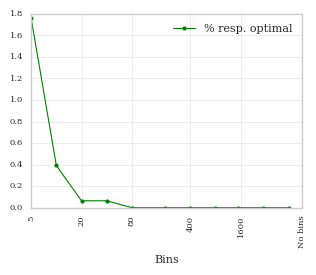

In [750]:
with matplotlib.style.context(paper_style):
    ax = plot_cost(df, "Periodic", 1000000, plot_phase_I=False)

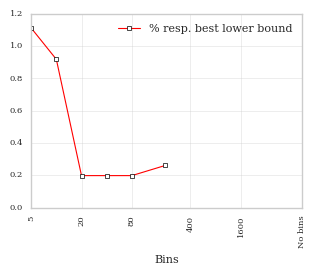

In [751]:
with matplotlib.style.context(paper_style):
    ax = plot_cost(df, "Periodic", 3000000, plot_phase_I=False)

As it can be seen in the above plot, the graph can be incomplete. In the example above there is no points for `max_bins` above 200. This happens when the solution of Phase I is not available for that number of bins, because of the timeout which aborted the solver. In such a case phase II cannot be performed (because Phase II needs as input the allocation found in phase I)

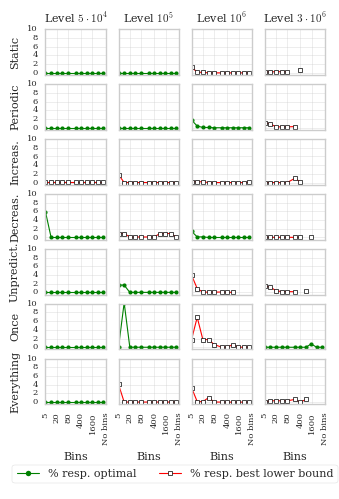

In [752]:
# Set a given ordering of the rows
casetitles = ["Static", "Periodic", "Increasing", "Decreasing",
              "Unpredictable", "Once", "Everything"]
levels = [5,10,100,300]

with matplotlib.style.context(paper_style):
    # Array of subplots
    f, axarr = plt.subplots (len(casetitles), len(levels), 
                             sharex=True, sharey=True, figsize=(15,30))

    for i,case in enumerate(casetitles):
        for j,level in enumerate(levels):
            plot_cost(df, case, level*10000, ax=axarr[i,j],
                          plot_phase_I = False, legend=False)

    f.set_size_inches(3.5,5)

    # Rows and columns titles (abridge some to fit in the available space)
    for ax, casetitle in zip(axarr[:,0], 
            ["Static", "Periodic", "Increas.", "Decreas.", 
             "Unpredict.", "Once", "Everything"]
            ):
        ax.set_ylabel(casetitle, rotation=90)
        ax.set_ylim([-0.5,10])
    
    for ax, level in zip(axarr[0,:], ["5\cdot10^4", "10^5", "10^6", 
                                      "3\cdot10^6" ]):
        ax.set_title("Level ${}$".format(level))
        ax.set_xlim(0,8760)
    patches0, labels = axarr[0,0].get_legend_handles_labels()
    patches1, labels = axarr[-1,-1].get_legend_handles_labels()
    patches = patches0 + patches1
    f.legend(patches, labels=["% resp. optimal", "% resp. best lower bound"], 
             bbox_to_anchor=(0.5, 0.05), loc="center",
             markerscale=1.3,
             ncol=2, shadow=False, fancybox=True, framealpha=1, 
             frameon=True)
    f.subplots_adjust(bottom=0.2, left=0.15,right=0.95, top=0.95)
    f.savefig("../reports/figures/fig-010-binning-analysis-error.pgf",
        bbox_inches = matplotlib.transforms.Bbox([[-0.05,0.05], [3.5, 5.1]]))

## Phase II (imperfect prediction)

In [778]:
agg_data = (df.loc[pd.IndexSlice[     # Seleccionar qué procesa:
                          :,          # Todos los Cases
                          :,     # Niveles de 50000 en adelante
                          "R",          # Fase 3 (realization)
                          20],]       # bins = 20
                       .reset_index() # Convertir multi-index en columnas
        .pivot_table(values="% overcost", 
                     index=["Case"], 
                     columns=["Base level"], 
                     aggfunc=np.max)
        )

# Select order of cases
cases = ["Static", "Periodic", 
         "Decreasing", "Increasing", "Once",
        "Everything", "Unpredictable"]
agg_data = agg_data.T[cases].T # Reorder rows

In [780]:
agg_data

Base level,50000,100000,1000000,3000000
Case,,,,
Static,0.00%,0.00%,0.14%,0.24%
Periodic,0.00%,0.00%,0.04%,0.20%
Decreasing,0.00%,0.10%,0.13%,0.04%
Increasing,0.04%,0.03%,0.21%,1.07%
Once,0.00%,0.00%,1.73%,0.00%
Everything,0.00%,0.13%,0.40%,-27.15%
Unpredictable,11.67%,44.80%,63.94%,114.21%


In [779]:
# Get the same data in tabular form
a=agg_data.copy()
# Replace by 0 values close enough
a[np.abs(a)< 1e-10] = 0
a[a==0]="0%"      # Replace those 0 by string "0%"

# Format all float numbers as percentages, two decimals
pd.options.display.float_format = "{:5.2f}%".format
print(a.to_latex())
pd.options.display.float_format = None

\begin{tabular}{lllrl}
\toprule
Base level & 50000   & 100000  &  1000000 & 3000000 \\
Case          &         &         &          &         \\
\midrule
Static        &      0\% &      0\% &    0.14\% &   0.24\% \\
Periodic      &      0\% &      0\% &    0.04\% &   0.20\% \\
Decreasing    &      0\% &   0.10\% &    0.13\% &   0.04\% \\
Increasing    &   0.04\% &   0.03\% &    0.21\% &   1.07\% \\
Once          &      0\% &      0\% &    1.73\% &      0\% \\
Everything    &      0\% &   0.13\% &    0.40\% & -27.15\% \\
Unpredictable &  11.67\% &  44.80\% &   63.94\% & 114.21\% \\
\bottomrule
\end{tabular}



NameError: name 'display' is not defined

# Real traces: Wikipedia

## General description

This section performs three different experiments. 

The first one is equivalent to the one performed with synthetic workloads, but in this case actual Wikipedia traces are used as characterization of the workload. We analyize the influence of binning over the time required to solve the problem and over the cost of the solution.

The second one analyzes the influence of the predictor in the cost of the solution.

The third one tests Lloovia in a multi-cloud environment, introducing Azure as a new provider. Azure does not provides reserved instances, and uses a different kind of limits, based on number of cores instead of number or types of VMs.

### Read the final solutions

The results of the first and second experiments are stored in a single dataframe:

In [628]:
wikidata = pd.read_pickle("../data/processed/all_wikipedia_results.pickle")
wikidata.index = wikidata.index.rename("Year", level=1)

In [629]:
wikidata

cost  seconds_to_solve  \
Case      Year Phase        max_bins                                    
Wikipedia 2013 Naive        40        423324.968397        463.076503   
               No predictor 40        716580.395000        769.975037   
               Oracle       8760      418067.586000       3099.316790   
          2014 I            5         382761.194740          0.056756   
                            10        348740.528288          0.095461   
                            20        333247.657055          0.181637   
                            40        325311.364055          0.288104   
                            80        321773.266205          0.477066   
                            200       319434.620205          1.179688   
                            400       318581.427219          4.898393   
                            800       318168.836247          9.086538   
                            1500      318010.671247         26.061860   
                            3000      317909.194233         54.694270   
                            6000      317859.223247        131.823503   
                            8760      317770.453000       2722.267405   
               II           5         367977.579740         15.258671   
                            10        326595.326288         84.908124   
                            20        318227.526055        136.788315   
                            40        318227.526055        140.805171   
                            80        317808.032205        167.557548   
                            200       317808.032205        161.571079   
                            400       317792.898219        158.948055   
                            800       317778.582247        193.093450   
                            1500      317778.582247        185.194589   
                            3000      317783.624233        162.419075   
                            6000      317778.582247        165.774775   
               Naive        40        363389.275877         18.046500   
               No predictor 40        542704.171000       1235.061124   
               Oracle       8760      317770.453000       2512.841090   

                                      seconds_to_create frac_gap  max_seconds  \
Case      Year Phase        max_bins                                            
Wikipedia 2013 Naive        40                42.315943     None          600   
               No predictor 40                60.571068     None         3600   
               Oracle       8760             423.409144     None         3600   
          2014 I            5                  0.063750    0.001         3600   
                            10                 0.144919    0.001         3600   
                            20                 0.224688    0.001         3600   
                            40                 0.401688    0.001         3600   
                            80                 0.635918    0.001         3600   
                            200                1.481575    0.001         3600   
                            400                2.897418    0.001         3600   
                            800                5.648974    0.001         3600   
                            1500              10.016334    0.001         3600   
                            3000              20.832419    0.001         3600   
                            6000              43.467211    0.001         3600   
                            8760             419.893840      NaN         3600   
               II           5                  4.788416     None          600   
                            10                19.860265     None          600   
                            20                29.596736     None          600   
                            40                29.661657     None          600   
                            80                32.348132     None          600   
 

Phase "I" and "II" are the analysis of the influence of binning, under a "Perfect prediction" scenario (the STWP for phase II is the same than the LTWP for phase I", and both are obtained from the English Wikipedia traces for that year)

Phases "Naive", "No predictor" and "Oracle" are related to the second experiment. They are performed for years 2013 and 2014. The Naive solution uses as LTWP the workload from the previous year. The "NoReserved" and "Oracle" do not consider the previous year workload, but only the current year one. "NoReserved" fulfills this demand using only on-demand instances, while "Oracle" solves the whole year (using Lloovia's PhaseI) to find the optimal solution.

Note that the oracle does not finish in the allotted time, so the optimal solution is not available. The value stored in "cost" is the best known lower bound at the time the solver was aborted.

## Binning analysis

This section uses traces of English Wikipedia corresponding to year 2014

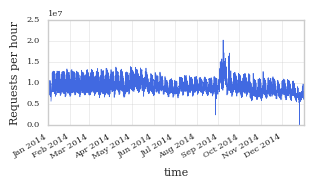

In [754]:
workload = pd.read_csv("../data/processed/traces_en_wikipedia.csv", 
                   sep=";", names=["time", "requests"], header=None)
workload.time = pd.to_datetime(workload.time)
workload = workload.set_index(workload.time)
with matplotlib.style.context(paper_style):
    a = workload['2014'].plot(legend=None, linewidth="0.5", 
                              figsize=(3.3, 1.5), color="RoyalBlue")
    a.set_ylabel("Requests per hour")
    plt.gcf().savefig("../reports/figures/fig-011-wikipedia-load-per-hour.pgf",
                     bbox_inches = 'tight')

### Time to solve

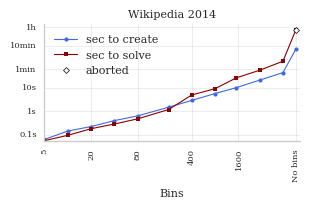

In [755]:
with matplotlib.style.context(paper_style):
    ax = time_plot(wikidata, "Wikipedia", 2014, plot_phase_II=False)
    plt.gcf().set_size_inches(3.3,1.5)
    plt.gcf().savefig("../reports/figures/fig-012-time-to-solve.pgf",
                     bbox_inches="tight")

As expected, the time increases exponentially with the number of bins. The case without bins was aborted after 1h. Note that the case with 20 bins finds one solution in less than 1 second.

### Cost of the solution

For each value of `max_bins` we compute `100*(cost-optimal)/optimal`. In this case `optimal` is not available, so we use the best bound instead.

In [631]:
phase_II_solution = wikidata.loc[("Wikipedia", 2014, "II")].copy()
best_bound = wikidata.loc[("Wikipedia", 2014, "I", 24*365)].cost

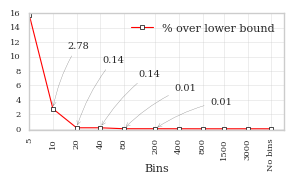

In [756]:
phase_II_solution["% over lower bound"] = np.round(
                    (phase_II_solution.cost - best_bound)/best_bound * 100, 5)

with matplotlib.style.context(paper_style):
    ax = phase_II_solution.plot(y="% over lower bound", color="red",
               figsize=(3.3,1.5), marker="s",
               markerfacecolor="white",
               markeredgecolor="k", 
               markeredgewidth=0.5
               )

    ax.set_xscale("log")
    requested_bins = [int(x) for x in phase_II_solution.index]
    ax.set_xticks(requested_bins)
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    ax.set_xlabel("Bins", labelpad=-5)
    ax.set_ylim(-0.1, 16)
    ax.set_xlim(4.9, 8760)
    annotate_subset = phase_II_solution.loc[10:200, ["% over lower bound"]
                                           ].to_records()
    
    # Annotate some of the values, since they are very small to read in 
    # the y-scale
    for n,(i,j) in enumerate(annotate_subset):
        ax.annotate("{:1.2f}".format(j),
                    xy=(i,j), 
                    textcoords="axes fraction",  fontsize=7,
                    xytext=(0.15+0.7/len(annotate_subset)*n, 
                            0.7-0.6/len(annotate_subset)*n),
                    arrowprops=dict(arrowstyle="->",  
                                    alpha=0.5, color="k", 
                                    connectionstyle="arc3,rad=0.1")
                    )
    plt.gcf().savefig("../reports/figures/fig-013-cost-vs-bins-labelled.pgf",
                    bbox_inches="tight")

This is Figure 13 in the paper. Note that for 20 bins (which we have seen that solves in less than 1 second), the overcost is very small (0.14%). Note also that this is the overcost with respect the lower bound, if the actual optimal were used it would be even smaller.

## Influence of the prediction

Wikipedia workload varies from one year to the next. In this section we compare three simple strategies to forecast the workload for the next year, and evaluate how Lloovia performs with each one, comparing it against a "oracle solution" which knows the future and thus the exact load for the next year. The strategies to compare are:

* Naive predictor. It simply uses the workload of the past year as a forecast for the next year
* No predictor. The workload is considered unpredictable, and this no attempt is made to find the optimal number of reserved machines. Only on-demand instances are used
* Oracle. Knows the future and thus can obtain the optimal solution. No other predictor can perform better.

Of course other predictors could be tested, but the point is to see that, even with a naive predictor, Lloovia can get important savings over the case in which no predictor is used, and that it is not so far of the optimal solution given by the oracle.

### Variation in Wikipedia's workload

We plot the avareage rph for each year, and see that it increases from 2012 to 2013, but decreases again in 2014 (this is figure 14 of the paper). We then decide to test the three predictors for years 2013 and 2014, to see two different cases for the naive predictor: one in which the actual workload is greater than the predicted, and other in which is the opposite.

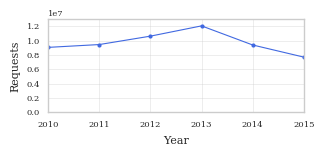

In [757]:
workload = pd.read_csv("../data/processed/traces_en_wikipedia.csv", 
                   sep=";", names=["time", "requests"], header=None)
workload.time = pd.to_datetime(workload.time)
workload = workload.set_index(workload.time)
with matplotlib.style.context(paper_style):
    workload.resample('A').mean().plot(marker="o", ylim=0, legend=None, 
                            figsize=(3.3, 1.2), color="RoyalBlue")
    plt.xlabel('Year')
    plt.ylabel('Requests')
    plt.gcf().savefig("../reports/figures/fig-014-wikipedia-load-per-year.pgf",
                     bbox_inches = 'tight')

### Comparison of predictors

The following (somwhat complex) pandas operations on the dataframe provide a summary of the results, used to create Table 8 in paper

In [677]:
summary_table = (wikidata.loc[pd.IndexSlice["Wikipedia", :, ["Oracle", "Naive", "No predictor"]], ["cost"]]
 .reset_index()
 .drop(["Case","max_bins"], axis=1)
 .rename(columns={"Phase": "Predictor"})
 .set_index(["Year", "Predictor"])
 .unstack("Predictor")
 .rename(columns={"Oracle": "Perfect predictor",
                  "Naive": "Naive predictor"})
)

summary_table

cost                               
Predictor Naive predictor No predictor Perfect predictor
Year                                                    
2013        423324.968397   716580.395        418067.586
2014        363389.275877   542704.171        317770.453

This can be plotted in a bar graph (not used in the paper)

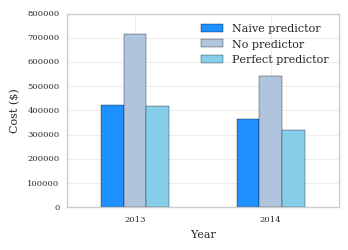

In [681]:
with matplotlib.style.context(paper_style):
    ax = summary_table.plot(kind="bar", 
                            color=["DodgerBlue", "LightSteelBlue", "SkyBlue"],
                            rot=0)
    ax.set_ylabel("Cost ($)")
    ax.legend(labels=summary_table.columns.levels[1])

## Multicloud case

### Load results

In [684]:
azure_only = lloovia.SolutionII.load("/tmp/interim/phaseII_PP/case_wikipedia_2014_multi_Azure_bins_40.pickle")
amazon_only = lloovia.SolutionII.load("/tmp/interim/phaseII_PP/case_wikipedia_2014_multi_Amazon_bins_40.pickle")
both = lloovia.SolutionII.load("/tmp/interim/phaseII_PP/case_wikipedia_2014_multi_Both_bins_40.pickle")

### Cloud infrastructure

In [697]:
perfs = (pd.DataFrame([i.__dict__ for i in both.problem.instances])
 [["name", "cloud", "performance", "price", "reserved"]]
 .assign(region=lambda x: x.cloud.astype(str).str.replace(" .*", ""))
 .assign(QPS=lambda x: x.performance/3600.0)
 .drop("cloud", axis=1)
# .reset_index()
 .pivot_table(index=["region", "name"], values=["QPS"])
 .rename(index={"US": "Amazon", "us-east-2": "Azure"})
 .sort_index()
 )
perfs = np.round(perfs, decimals=2)
perfs

QPS
region name                    
Amazon c4.2xlarge       2592.50
       c4.xlarge        1468.00
       m4.2xlarge       2510.00
       m4.large          636.00
       m4.xlarge        1316.00
Azure  A5                260.67
       A6                594.00
       Basic_A0           56.67
       Basic_A1           81.33
       Basic_A2          178.00
       Basic_A3          657.33
       ExtraSmall         54.67
       Large             561.33
       Medium            299.00
       Small             109.00
       Standard_D11_v2   660.00
       Standard_D12_v2  1621.67
       Standard_D1_v2    440.67
       Standard_D2_v2    682.33
       Standard_D3_v2   1560.00

In [699]:
print(perfs.to_latex())

\begin{tabular}{llr}
\toprule
       &    &      QPS \\
region & name &          \\
\midrule
Amazon & c4.2xlarge &  2592.50 \\
       & c4.xlarge &  1468.00 \\
       & m4.2xlarge &  2510.00 \\
       & m4.large &   636.00 \\
       & m4.xlarge &  1316.00 \\
Azure & A5 &   260.67 \\
       & A6 &   594.00 \\
       & Basic\_A0 &    56.67 \\
       & Basic\_A1 &    81.33 \\
       & Basic\_A2 &   178.00 \\
       & Basic\_A3 &   657.33 \\
       & ExtraSmall &    54.67 \\
       & Large &   561.33 \\
       & Medium &   299.00 \\
       & Small &   109.00 \\
       & Standard\_D11\_v2 &   660.00 \\
       & Standard\_D12\_v2 &  1621.67 \\
       & Standard\_D1\_v2 &   440.67 \\
       & Standard\_D2\_v2 &   682.33 \\
       & Standard\_D3\_v2 &  1560.00 \\
\bottomrule
\end{tabular}



In [701]:
azure_only.get_cost()

3490.989000000115

### Comparison of results

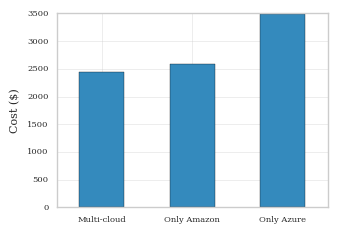

In [711]:
from collections import OrderedDict
cost_multicloud = OrderedDict()
cost_multicloud['Multi-cloud'] =  both.get_cost()
cost_multicloud['Only Amazon'] = amazon_only.get_cost()
cost_multicloud['Only Azure'] = azure_only.get_cost()
c_multicloud = cost_multicloud['Multi-cloud']

s = pd.Series(cost_multicloud)
costdf = pd.DataFrame(s, columns=["Cost ($)"])
costdf['% increase (vs. multicloud)'] = (costdf["Cost ($)"] -
                                          c_multicloud) * 100  / c_multicloud

with matplotlib.style.context(paper_style):
    costdf["Cost ($)"].plot(kind="bar", color="#348ABD", rot=0)
    plt.ylabel("Cost ($)")

In [712]:
costdf

,Cost ($),% increase (vs. multicloud)
Multi-cloud,2450.69037,0.000000
Only Amazon,2582.30237,5.370405
Only Azure,3490.98900,42.449207


In [713]:
print(costdf.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    Cost (\$) &  \% increase (vs. multicloud) \\
\midrule
Multi-cloud &  2450.69037 &                     0.000000 \\
Only Amazon &  2582.30237 &                     5.370405 \\
Only Azure  &  3490.98900 &                    42.449207 \\
\bottomrule
\end{tabular}



### Plot of performance vs workload per cloud provider

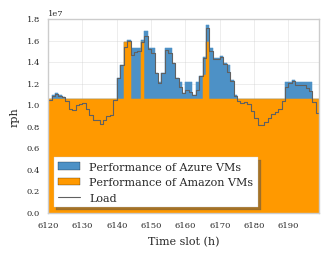

In [760]:
solution_multicloud = both.get_cost_and_perf_dataframe()

perf_of_amazon = solution_multicloud.loc[:,("Performance","amazon")].sum(axis=1)
perf_of_azure = solution_multicloud.loc[:,("Performance","azure")].sum(axis=1)
perf_global = perf_of_azure + perf_of_amazon
workload = both.problem.workload

aux = pd.DataFrame(dict(
        performance = perf_global,
        perf_azure = perf_of_azure,
        perf_amazon = perf_of_amazon,
        load = workload
    ))

def make_steps(df):
    # Double the data, to make a stepwise function
    aux = pd.DataFrame()
    for c in df.columns:
        y = df[c].values
        yy = np.array([y,y]).flatten("F")
        aux[c] = yy[1:]
    x = df.index
    aux["time"] = np.array([x,x]).flatten('F')[:-1]
    return aux

import matplotlib.patches as mpatches

xlim = (6120, 6200)
sli = slice(*xlim)
with matplotlib.style.context(paper_style):
    ax=make_steps(aux.iloc[sli]).plot(x="time", y="performance", kind="area", lw=0.2,
                                     label="Performance of Azure VMs", color="#4D91C6")
    ax=make_steps(aux.iloc[sli]).plot(x="time", y="perf_amazon", ax=ax, ylim=(0e7, None),
                               kind="area", color="#ff9900", lw=0.2, 
                                      label="Performance of Amazon VMs")
    ax=make_steps(aux.iloc[sli]).plot(x="time", y="load", ax=ax, ylim = (0e7, None),
                                     lw=0.8, label="Load", color="#606060"
                                     )
    ax.set_ylabel("rph")
    ax.set_xlabel("Time slot (h)")
    # La leyenda no sale correctamente si la intento pintar mediante
    # ax.legend(), pues en lugar de rectángulos sólidos pinta líneas
    # Así que capturo los dibujadores originales:
    handles, labels = ax.get_legend_handles_labels()
    
    # Y redefino los dos primeros correspondientes a áreas para que use rectángulos
    new_handles = [mpatches.Rectangle((0, 1), 1, 1, fc=handle.get_color(),
                                              linewidth=handle.get_linewidth(),
                                              alpha=handle.get_alpha())
                                  for handle in handles[:-1]]
    # El tercero lo dejo como estaba
    new_handles.append(handles[-1])
    # Pinto la leyenda usando los nuevos handles
    ax.legend(new_handles ,labels,
            loc="lower left", shadow=True, frameon=True)
plt.gcf().savefig("../reports/figures/fig-015-multicloud-performance.pgf", bbox_inches="tight")